In [70]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox
# from scipy import stats

# Data Collection & Understanding

In [2]:
# load data
file_to_load = "data/us_treasury_yields_daily.csv"
original_data = pd.read_csv(file_to_load)

raw_data = original_data.copy()
# convert date to datetime format
raw_data['date'] = pd.to_datetime(raw_data['date'])

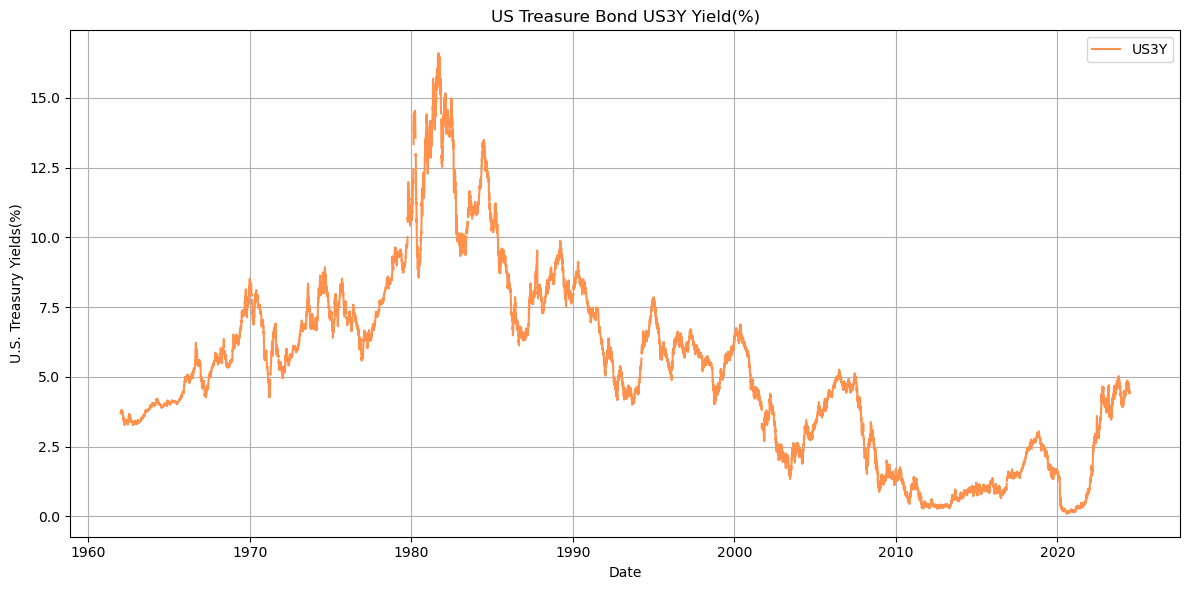

In [3]:
# make plot check selected data
plt.figure(figsize=(12,6))
plt.plot(raw_data.date, raw_data.US3Y, label = 'US3Y', color = '#FF914D')
plt.title('US Treasure Bond US3Y Yield(%)')
plt.xlabel('Date')
plt.ylabel('U.S. Treasury Yields(%)')
plt.tight_layout()
plt.legend()
plt.grid(True)
plt.show()

# Data Preprocessing
## Handling Missing Values
### Filling Missing Values Best Practice for Stock Data
 1. Fill missing values before differencing, unless missingness is small and caused by differencing itself.
 2. For non-trading days (weekends/holidays), decide whether to:
Forward fill (common for stock closing prices), or
Remove them entirely (if modeling only trading days).

In [4]:
# convert date column to index
data = raw_data.set_index('date').asfreq('d')
# Select US3Y for Time Series Analysis
data['US3Y'] = data['US3Y'].fillna(method='ffill')
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22817 entries, 1962-01-02 to 2024-06-21
Freq: D
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   US1M    5726 non-null   float64
 1   US3M    10702 non-null  float64
 2   US6M    10702 non-null  float64
 3   US1Y    15604 non-null  float64
 4   US2Y    12012 non-null  float64
 5   US3Y    22817 non-null  float64
 6   US5Y    15604 non-null  float64
 7   US7Y    13734 non-null  float64
 8   US10Y   15604 non-null  float64
 9   US20Y   13915 non-null  float64
 10  US30Y   11834 non-null  float64
dtypes: float64(11)
memory usage: 2.1 MB


### Select data date range

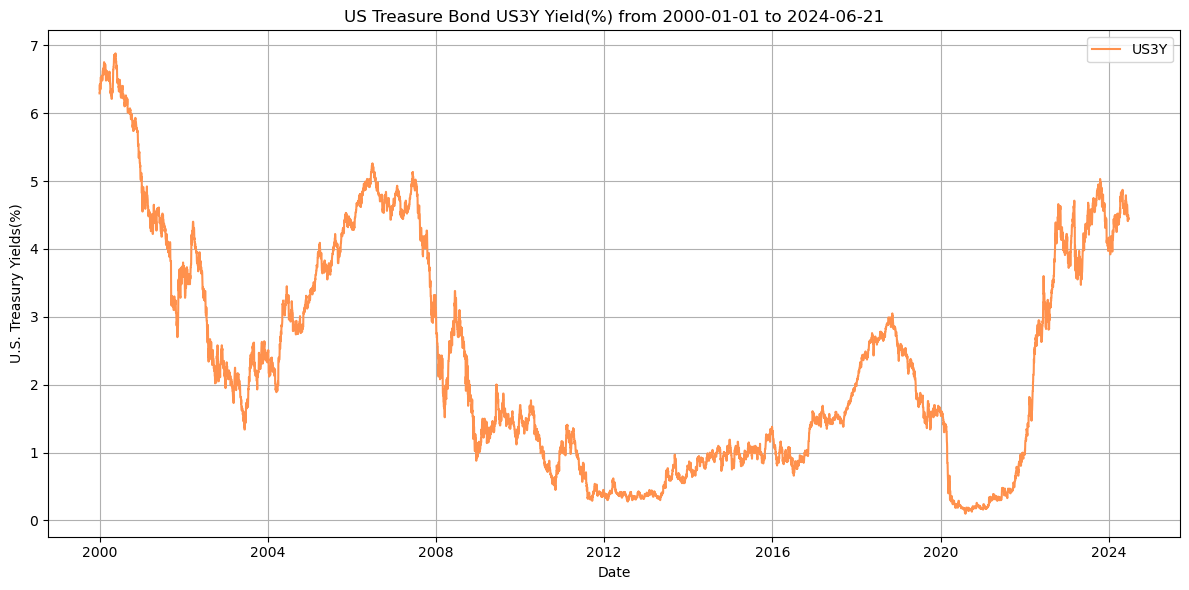

In [5]:
start = '2000-01-01'
end = data.index[-1].strftime('%Y-%m-%d')
filtered_data = data.loc[start:]

# filtered_data = data
filtered_data.head()

plt.figure(figsize=(12,6))
plt.plot(filtered_data.index, filtered_data.US3Y, label = 'US3Y', color = '#FF914D')
plt.title(f'US Treasure Bond US3Y Yield(%) from {start} to {end}')
plt.xlabel('Date')
plt.ylabel('U.S. Treasury Yields(%)')
plt.tight_layout()
plt.legend()
plt.grid(True)
plt.show()

# Exploratory Data Analysis (EDA)
## STL Decomposition

In [6]:
# # perform STL decomposition
# stl = STL(filtered_data.US3Y, period=90)
# result = stl.fit()

# # plot the decomposition components
# plt.figure(figsize = (14,10))
# plt.subplot(411)
# plt.plot(result.observed, label = 'Original', color = '#FF914D')
# plt.legend(loc = 'upper left')

# plt.subplot(412)
# plt.plot(result.trend, label = 'Trend', color = '#FF914D')
# plt.legend(loc = 'upper left')

# plt.subplot(413)
# plt.plot(result.seasonal, label = 'Seasonal', color = '#FF914D')
# plt.legend(loc = 'upper left')
# plt.subplot(414)
# plt.plot(result.resid, label = 'Residual', color = '#FF914D')
# plt.legend(loc = 'upper left')
# plt.tight_layout()
# plt.show()

## Smoothing Data 

In [7]:
# from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

# # using differecing method to sta
# ses_model = ExponentialSmoothing(stationary_data['US3Y']).fit(smoothing_level = 0.7)
# stationary_data['US3Y_SES'] = ses_model.fittedvalues

# # Double Exponential Smoothing (DES) - Holt's Linear trend model
# des_model = ExponentialSmoothing(stationary_data['US3Y'], trend = 'add').fit(smoothing_level = 0.7)
# stationary_data['US3Y_DES'] = des_model.fittedvalues

# # # Triple Exponential Smoothing (TES) - Holt's-Winters method
# tes_model = ExponentialSmoothing(stationary_data['US3Y'], trend = 'add', seasonal = 'add', seasonal_periods = 12).fit(smoothing_level = 0.7)
# stationary_data['US3Y_TES'] = tes_model.fittedvalues


# # Plotting
# plt.figure(figsize = (10, 6))
# plt.plot(stationary_data['US3Y'], label = 'US3Y', color = 'blue', alpha = 0.5)
# plt.plot(stationary_data['US3Y_SES'], label = 'SES (Single Expoential Smoothing)', color = 'green')
# plt.plot(stationary_data['US3Y_DES'], label = 'DES (Double Exponential Smoothing)', color = 'orange')
# plt.plot(stationary_data['US3Y_TES'], label = 'TES (Triple Exponential Smoothing)', color = 'red')

# plt.title('US3Y Stationary with SES, DES, and TES')
# plt.xlabel('Date')
# plt.ylabel('Rate (%)')
# plt.legend()
# plt.grid()
# plt.show()

# Stationarity Test
## Use Augmented Dickey-Fuller (ADF)

In [8]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [9]:
check_stationarity(filtered_data.US3Y)

ADF Statistic: -2.350025
p-value: 0.156341
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Non-stationary


## Making Data Stationary

In [10]:
# first order difference
rate_diff = filtered_data.US3Y.diff()
check_stationarity(rate_diff.dropna())

#log transformation
rate_log = np.log(filtered_data.US3Y.dropna())
check_stationarity(rate_log)

#square root transformation
rate_sqrt = np.sqrt(filtered_data.US3Y.dropna())
check_stationarity(rate_sqrt)

ADF Statistic: -15.401199
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary
ADF Statistic: -1.924947
p-value: 0.320418
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Non-stationary
ADF Statistic: -1.894506
p-value: 0.334650
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Non-stationary


### Choosing differencing method

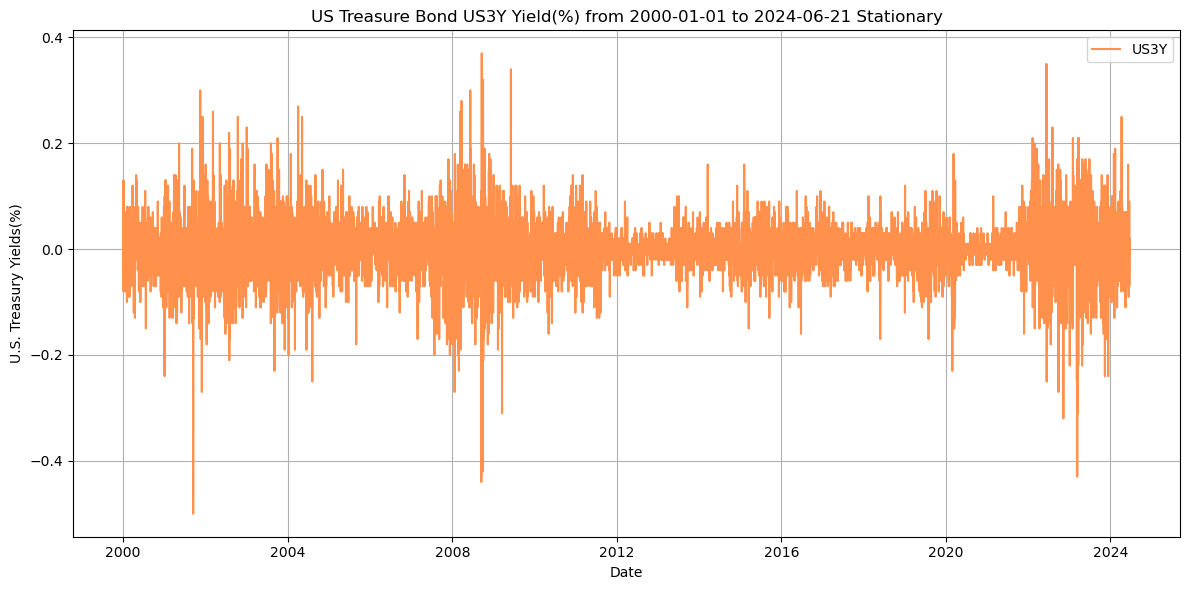

In [11]:
stationary_data = rate_diff.dropna().to_frame()
# stationary_data = rate_diff.dropna()
# show stationary data
plt.figure(figsize=(12,6))
plt.plot(stationary_data.index, stationary_data.US3Y, label = 'US3Y', color = '#FF914D')
plt.title(f'US Treasure Bond US3Y Yield(%) from {start} to {end} Stationary')
plt.xlabel('Date')
plt.ylabel('U.S. Treasury Yields(%)')
plt.tight_layout()
plt.legend()
plt.grid(True)
plt.show()

# Time Series Forecasting Models
## ACF and PACF Plot

In [12]:
# take a period as a test data
n_periods = 30

# select train and test data at their original scale
train_true, test_true = filtered_data['US3Y'][:-n_periods], filtered_data['US3Y'][-n_periods:]
# select train and test data (it doesn't matter if we stationary test data here since we won't use it)
train_diff, test_diff = stationary_data['US3Y'][:-n_periods], stationary_data['US3Y'][-n_periods:]

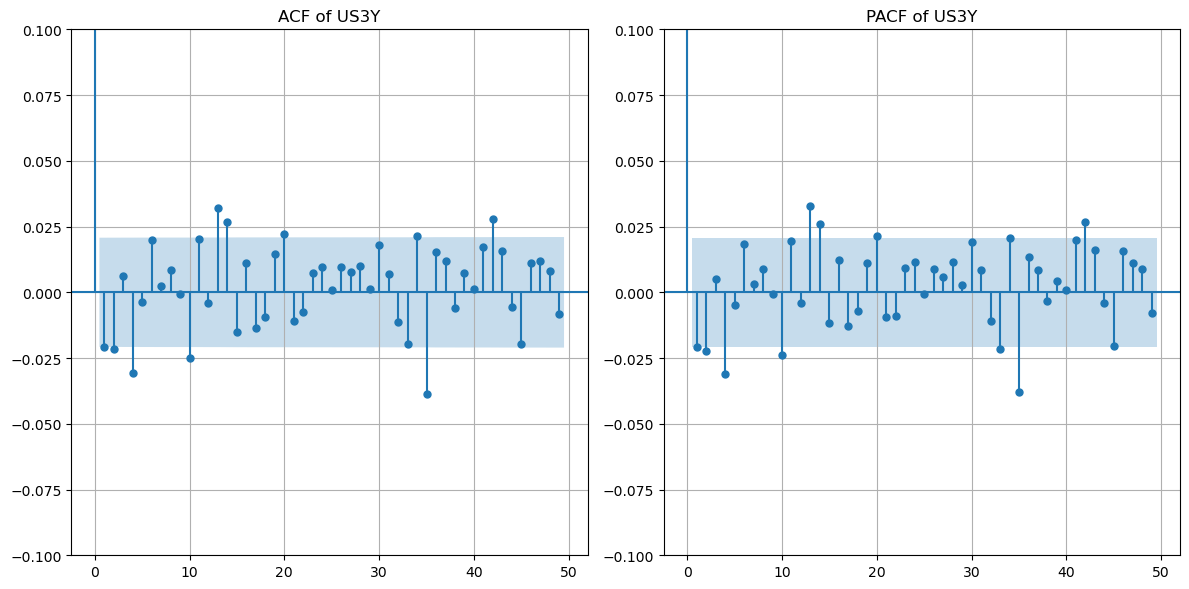

In [13]:
plt.figure(figsize = (12, 6))
# ACF Plot
plt.subplot(1, 2, 1)
plot_acf(train_diff, ax=plt.gca(), lags = range(0, 50))
# Adjust ylim for better visulization
plt.ylim(-0.1, 0.1)
plt.title('ACF of US3Y')
plt.grid(True)
# PACF Plot
plt.subplot(1, 2, 2)
plot_pacf(train_diff, ax=plt.gca(), lags = range(0, 50), method = 'ywm')
# plot_pacf(train_diff, ax=plt.gca(), lags = range(0, 50), method = 'yw')
# Adjust ylim for better visulization
plt.ylim(-0.1, 0.1)
plt.title('PACF of US3Y')
plt.grid(True)
plt.tight_layout()

plt.show()

## Use auto_arima

In [14]:
# %%time
# # Fit Auto ARIMA model
# model = auto_arima(
#     train_diff,          # original series (let auto_arima handle differencing)
#     start_p = 1, max_p = 50, 
#     start_q = 1, max_q = 50,
#     d = None,            # let auto_arima determine differencing order
#     seasonal=False,      # set True if data is seasonal
#     stepwise=True,       # use stepwise search (faster)
#     suppress_warnings=True,
#     trace=True,           # print model fitting progress
#     n_jobs = -1
# )
# # Summary of the model
# print(model.summary())

In [15]:
# Plot the actual vs predicted values
def test_plot(test, predict):
    plt.figure(figsize = (10, 4))
    plt.plot(test.index, test, label = 'Test data')
    plt.plot(test.index, predict, color = 'red', linestyle = '--', label = 'Predicted Prices')
    plt.title('US3Y rate: Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel('Rate %')
    plt.tight_layout()
    plt.legend()
    plt.show()

In [16]:
def evaluate(model, test, predict):
    # evaluating model using RMSE score
    rmse = round(np.sqrt(mean_squared_error(test, predict)), 5)
    print('RMSE: ', rmse)
    # aic and bic
    aic = model.aic
    bic = model.bic
    print(f'Akaike Information Criterion (AIC): {aic}')
    print(f'Bayesian Information Criterion (BIC) {bic}')

Best model:  ARIMA(31,1,0)(0,0,0)[0] 

## Primary AR Model 

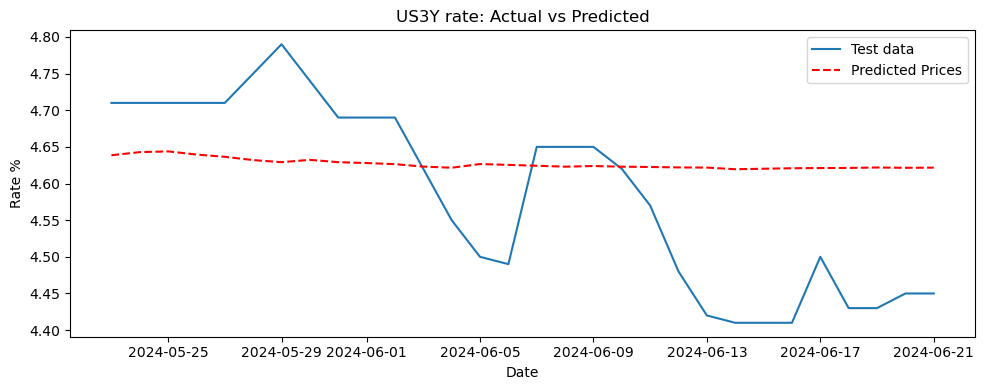

RMSE:  0.12544
Akaike Information Criterion (AIC): -28671.728249447497
Bayesian Information Criterion (BIC) -28437.71802439224


In [17]:
# Fit the Autoregressive model (AR) to the training data
model = AutoReg(train_diff, lags = 31)
model_ar = model.fit()

# Make predictions on the test data
pred_diff = model_ar.predict(
    start = len(train_diff),
    end = len(train_diff) + len(test_diff) - 1,
    dynamic = False)

# revert prediction to actual values
predict_original_ar = pred_diff.cumsum() + filtered_data['US3Y'][-(n_periods + 1)]

# Plot the actual vs predicted values
test_plot(test_true, predict_original_ar)

# evaluating model using RMSE score
evaluate(model_ar, test_true, predict_original_ar)

In [18]:
# pred_diff

## Primary MA Model

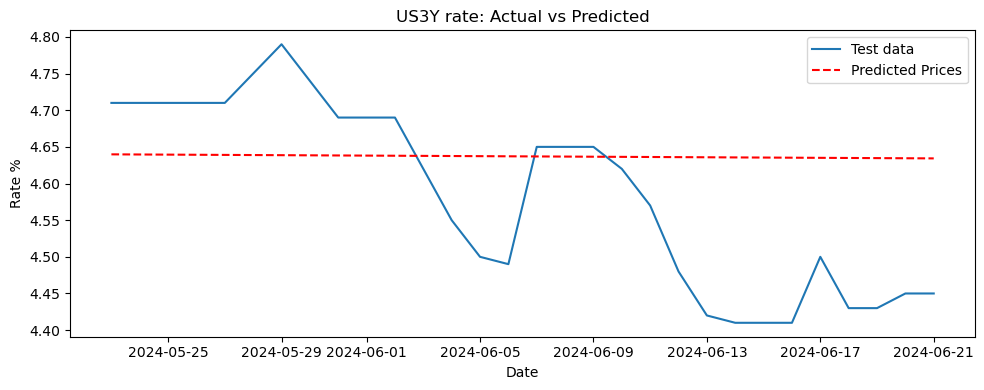

RMSE:  0.13237
Akaike Information Criterion (AIC): -28770.26024780144
Bayesian Information Criterion (BIC) -28756.070837744686


In [19]:
# Fit the Moving Average (MA) model to the training data
model = ARIMA(train_diff, order=(0, 0, 0))
model_ma = model.fit()

# Make predictions on the test data
pred_diff = model_ma.predict(
    start = len(train_diff),
    end = len(train_diff) + len(test_diff) - 1,
    dynamic = False)

# revert prediction to actual values
predict_original_ma = pred_diff.cumsum() + filtered_data['US3Y'][-(n_periods + 1)]

# Plot the actual vs predicted values
test_plot(test_true, predict_original_ma)

# evaluating model using RMSE score
evaluate(model_ma, test_true, predict_original_ma)

## Primary ARIMA

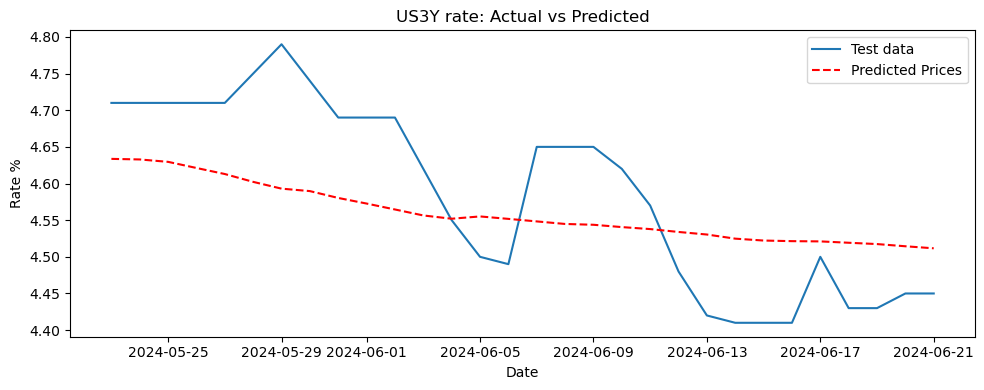

RMSE:  0.09807
Akaike Information Criterion (AIC): -28534.73791775821
Bayesian Information Criterion (BIC) -28307.710949328393
CPU times: total: 19.7 s
Wall time: 12.2 s


In [20]:
%%time
# Fit the ARIMA model to the training data
model = ARIMA(train_diff, order=(31, 1, 0))
model_arima = model.fit()

# Make predictions on the test data
pred_diff = model_arima.predict(
    start = len(train_diff),
    end = len(train_diff) + len(test_diff) - 1,
    dynamic = False)

# revert prediction to actual values
predict_original_arima = pred_diff.cumsum() + filtered_data['US3Y'][-(n_periods + 1)]

# Plot the actual vs predicted values
test_plot(test_true, predict_original_arima)

# evaluating model using RMSE score
evaluate(model_arima, test_true, predict_original_arima)

## Primary Holt's-Winters method

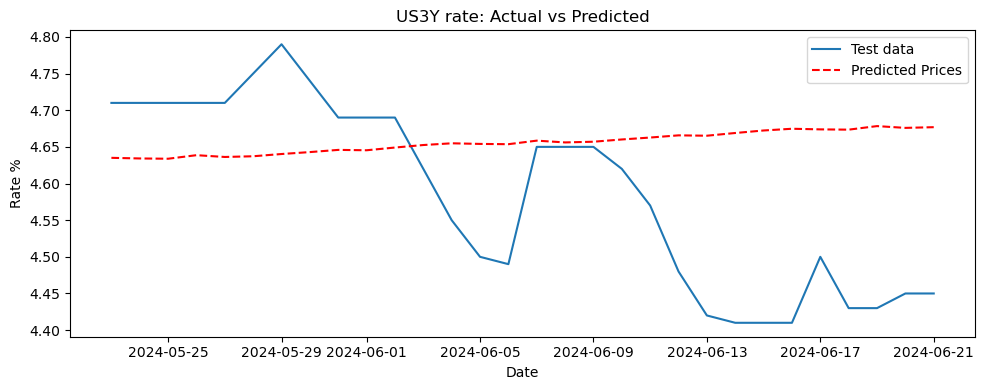

RMSE:  0.15331


In [63]:
# Triple Exponential Smoothing (TES) - Holt's-Winters method
tes_model = ExponentialSmoothing(train_true, 
                                 trend = 'add', 
                                 seasonal = 'add', 
                                 seasonal_periods = 12).fit(smoothing_level = 0.7)
pred_tes = tes_model.forecast(n_periods)

test_plot(test_true, pred_tes)
# evaluating model using RMSE score
rmse = round(np.sqrt(mean_squared_error(test_true, pred_tes)), 5)
print('RMSE: ', rmse)

# Time series prediction on residuals
## Workflow
1. Fit a primary model to capture trend and seasonality (e.g., ARIMA, Prophet, STL decomposition).
2. Extract residuals:
   Residuals=Actual Values−Model Predictions
3. Check residual stationarity using ADF or KPSS test.
4. Fit a secondary model on residuals (e.g., AR, ARIMA, or ML models like XGBoost or LSTM if patterns exist).
5. Forecast residuals for the desired horizon.
6. Combine predictions:
   Final Forecast=Primary Model Forecast+Residual Forecast

## Primary AR + Secondary ARIMA

In [21]:
### Step 1: Fit initial AR model
# predict training_diff, it is possible for an AutoReg model to produce NaN (Not a Number) predictions
pred_tr_diff = model_ar.predict(start=0, end=len(train_diff)-1)
# pred_tr_diff = pred_tr_diff.fillna(0)
pred_tr_diff = pred_tr_diff.fillna(method = 'bfill')
# transform the differencing training data back to its original scale 
predict_tr_ar_original = pd.concat ([filtered_data['US3Y'].head(1), 
                              pred_tr_diff.cumsum() + filtered_data['US3Y'][0]])

### Step 2: Get residuals
# Residuals=Actual Values−Model Predictions
residuals_ar = train_true - predict_tr_ar_original

### Step 3: Check stationarity of residuals
check_stationarity(residuals_ar)
# first order difference
res_diff_ar = residuals_ar.diff()
check_stationarity(res_diff_ar.dropna())

### Step 4: Fit ARIMA model on residuals (if p-value < 0.05, residuals are stationary)
stationary_residuals_ar = res_diff_ar.dropna().to_frame()

ADF Statistic: -1.489740
p-value: 0.538581
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Non-stationary
ADF Statistic: -94.447320
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


### Ljung-Box test 
checks whether residuals from a time series model are independent (white noise) or show autocorrelation at lags.
* p-value > 0.05 → Fail to reject H₀ → residuals show no significant autocorrelation.
* p-value ≤ 0.05 → Reject H₀ → residuals are autocorrelated → model may need improvement.

In [72]:
# Ljung-Box test
lb_test = acorr_ljungbox(residuals_ar, lags=[10], return_df=True)
print(lb_test)

         lb_stat  lb_pvalue
10  88110.769823        0.0


#### ACF and PACF Plot of Residuals

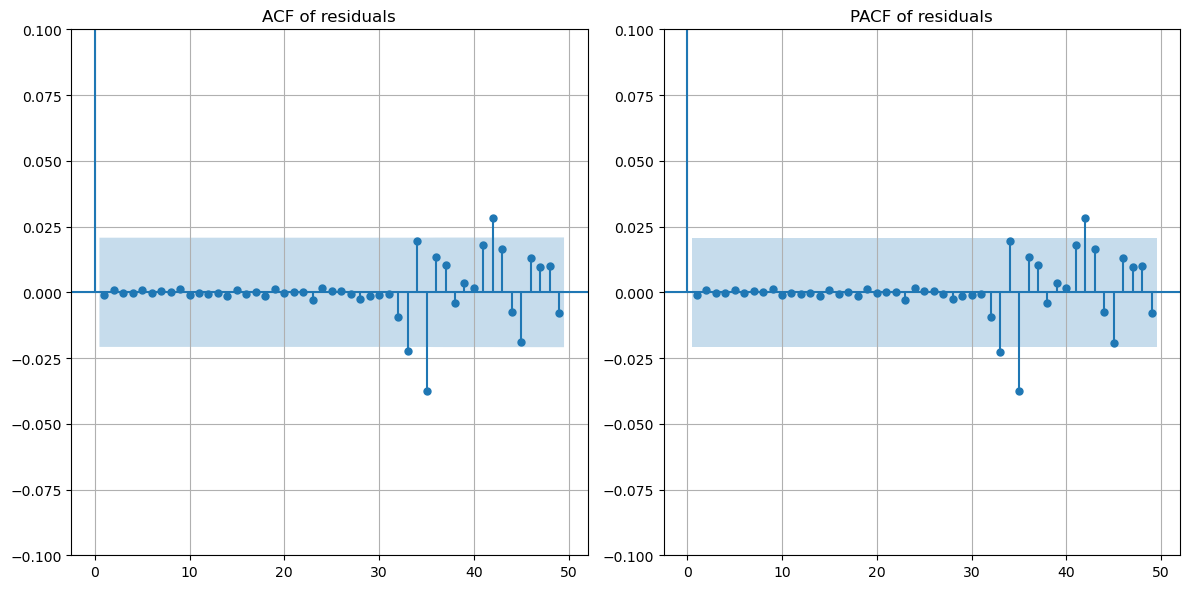

In [22]:
plt.figure(figsize = (12, 6))
# ACF Plot
plt.subplot(1, 2, 1)
plot_acf(stationary_residuals_ar, ax=plt.gca(), lags = range(0, 50))
plt.ylim(-0.1, 0.1)
plt.title('ACF of residuals')
plt.grid(True)
# PACF Plot
plt.subplot(1, 2, 2)
plot_pacf(stationary_residuals_ar, ax=plt.gca(), lags = range(0, 50), method = 'ywm')
plt.ylim(-0.1, 0.1)
plt.title('PACF of residuals')
plt.grid(True)
plt.tight_layout()

plt.show()

#### Use auto_arima

In [23]:
# %%time
# # Fit Auto ARIMA model
# model = auto_arima(
#     stationary_residuals_ar, # original series (let auto_arima handle differencing)
#     start_p = 1, max_p = 50, 
#     start_q = 1, max_q = 50,
#     d = None,            # let auto_arima determine differencing order
#     seasonal=False,      # set True if data is seasonal
#     stepwise=True,       # use stepwise search (faster)
#     suppress_warnings=True,
#     trace=True,           # print model fitting progress
#     n_jobs = -1
# )
# # Summary of the model
# print(model.summary())

Best model:  ARIMA(31,1,0)(0,0,0)[0]   

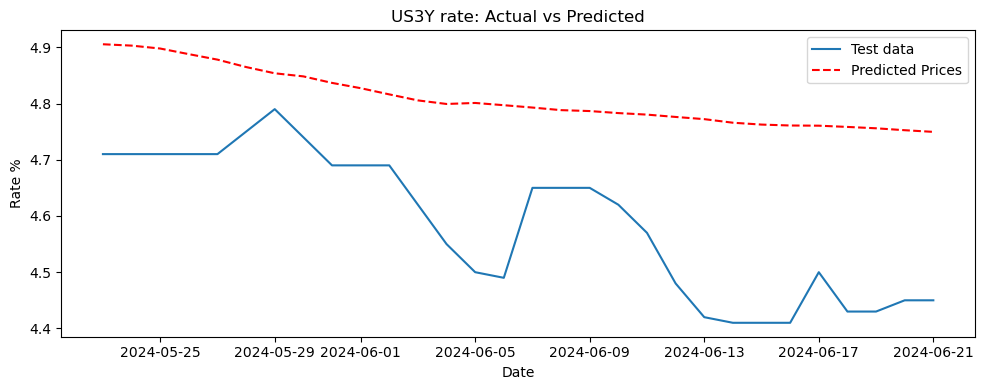

RMSE:  0.2391


In [24]:
# Fit the ARIMA model (ARIMA) to the training residual data
model = ARIMA(stationary_residuals_ar, order=(31, 1, 0))
model_res_arima = model.fit()

# Make predictions on residue
pred_res_diff = model_res_arima.forecast(steps=n_periods, dynamic=False)
# revert prediction to actual values
predict_res_original = pred_res_diff.cumsum() + residuals_ar[-1]

final_forecast = predict_original_ar + predict_res_original 

# Plot the actual vs predicted values
test_plot(test_true, final_forecast)

# evaluating model using RMSE score
rmse = round(np.sqrt(mean_squared_error(test_true, final_forecast)), 5)
print('RMSE: ', rmse)

## Primary ARIMA + Secondary ARIMA

In [25]:
### Step 1: Fit initial AR model
# predict training_diff, it is possible for an AutoReg model to produce NaN (Not a Number) predictions
pred_tr_diff = model_arima.predict(start=0, end=len(train_diff)-1)
# transform the differencing training data back to its original scale 
predict_tr_arima_original = pd.concat ([filtered_data['US3Y'].head(1), 
                              pred_tr_diff.cumsum() + filtered_data['US3Y'][0]])

### Step 2: Get residuals
# Residuals=Actual Values−Model Predictions
residuals_arima = train_true - predict_tr_arima_original

### Step 3: Check stationarity of residuals
check_stationarity(residuals_arima)

### Step 4: Fit ARIMA model on residuals (if p-value < 0.05, residuals are stationary)
residuals_arima = residuals_arima.to_frame()

ADF Statistic: -14.668093
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


In [75]:
# Ljung-Box test
lb_test = acorr_ljungbox(residuals_arima, lags=[10], return_df=True)
print(lb_test)

         lb_stat  lb_pvalue
10  54805.858709        0.0


In [26]:
# test_plot(train_true, predict_tr_arima_original)

#### ACF and PACF Plot of Residuals

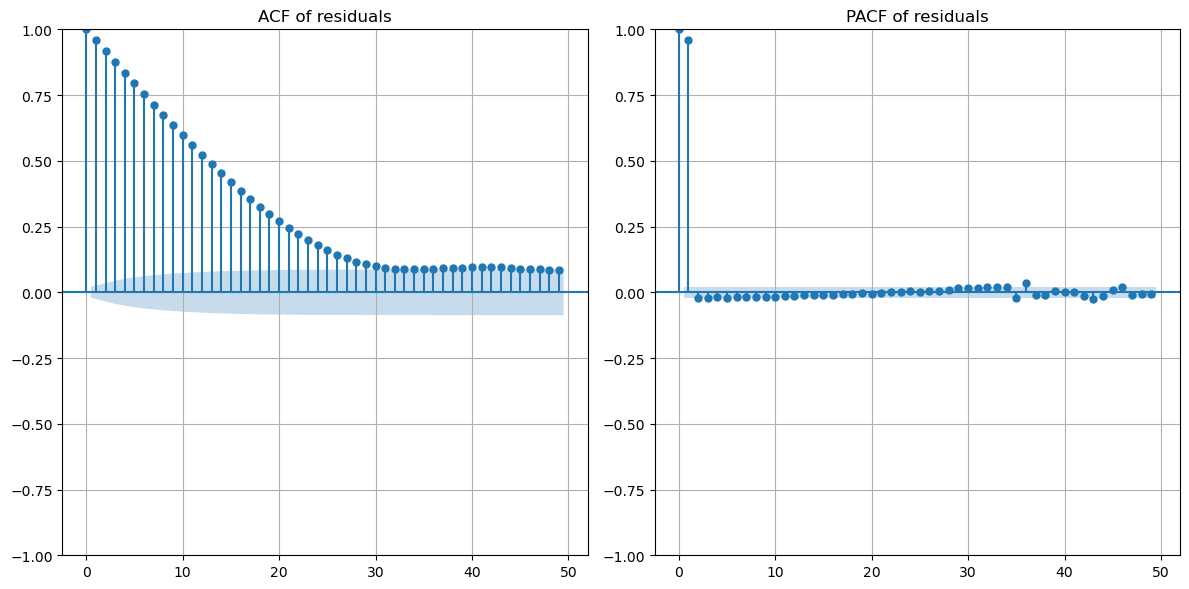

In [27]:
plt.figure(figsize = (12, 6))
# ACF Plot
plt.subplot(1, 2, 1)
plot_acf(residuals_arima[0], ax=plt.gca(), lags = range(0, 50))
# plt.ylim(-0.1, 0.1)
plt.title('ACF of residuals')
plt.grid(True)
# PACF Plot
plt.subplot(1, 2, 2)
plot_pacf(residuals_arima[0], ax=plt.gca(), lags = range(0, 50), method = 'ywm')
# plt.ylim(-0.1, 0.1)
plt.title('PACF of residuals')
plt.grid(True)
plt.tight_layout()

plt.show()

In [28]:
%%time
# Fit Auto ARIMA model
model = auto_arima(
    residuals_arima, # original series (let auto_arima handle differencing)
    start_p = 1, max_p = 30, 
    start_q = 1, max_q = 30,
    d = None,            # let auto_arima determine differencing order
    seasonal=False,      # set True if data is seasonal
    stepwise=True,       # use stepwise search (faster)
    suppress_warnings=True,
    trace=True,           # print model fitting progress
    n_jobs = -1
)
# Summary of the model
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-28589.199, Time=1.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-28593.199, Time=0.47 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-28591.203, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-28591.196, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-28595.194, Time=0.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.998 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8909
Model:               SARIMAX(0, 1, 0)   Log Likelihood               14298.597
Date:                Wed, 27 Aug 2025   AIC                         -28595.194
Time:                        12:06:48   BIC                         -28588.099
Sample:                    01-01-2000   HQIC                        -28592.778
                         - 05-22-2024                             

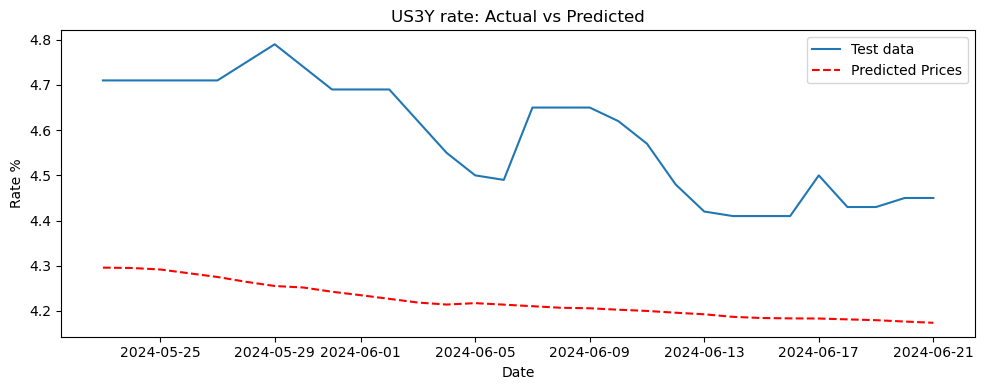

RMSE:  0.37671


In [29]:
# Fit the ARIMA model (ARIMA) to the training residual data
model = ARIMA(residuals_arima, order=(0, 1, 0))
model_res_arima = model.fit()

# Make predictions on residue
pred_res = model_res_arima.forecast(steps=n_periods, dynamic=False)

final_forecast = predict_original_arima + pred_res
# final_forecast = predict_original_arima 
# Plot the actual vs predicted values
test_plot(test_true, final_forecast)

# evaluating model using RMSE score
rmse = round(np.sqrt(mean_squared_error(test_true, final_forecast)), 5)
print('RMSE: ', rmse)

## Primary ARIMA + Secondary AR

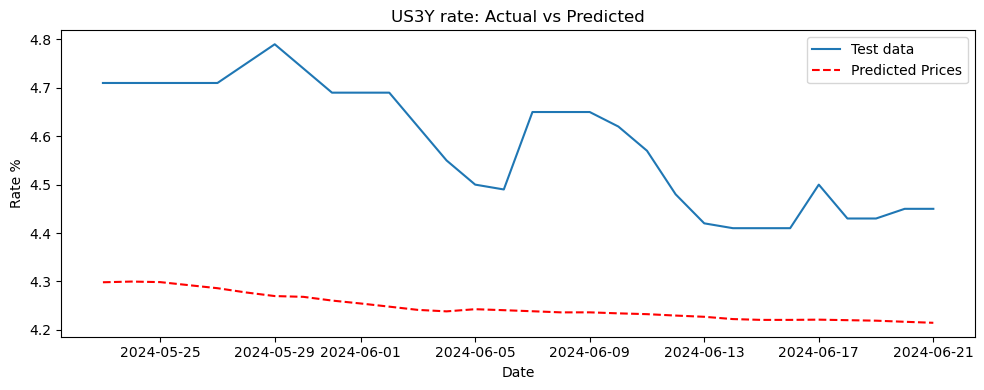

RMSE:  0.35477


In [30]:
# Fit the ARIMA model (ARIMA) to the training residual data
model = AutoReg(residuals_arima[0], lags = 1)
model_res_ar = model.fit()

# Make predictions on residue
pred_res = model_res_ar.forecast(steps=n_periods)
final_forecast = predict_original_arima + pred_res
# final_forecast = predict_original_arima 
# Plot the actual vs predicted values
test_plot(test_true, final_forecast)

# evaluating model using RMSE score
rmse = round(np.sqrt(mean_squared_error(test_true, final_forecast)), 5)
print('RMSE: ', rmse)

## Primary ARIMA + Secondary Holt's-Winters method

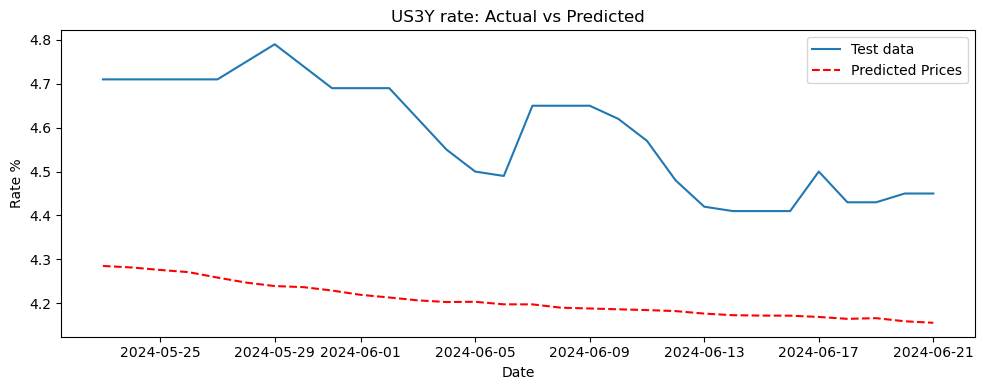

RMSE:  0.39117


In [31]:
tes_model = ExponentialSmoothing(residuals_arima, 
                                 trend = 'add', 
                                 seasonal = 'add', 
                                 seasonal_periods = 12).fit(smoothing_level = 0.7)
pred_res = tes_model.forecast(n_periods)

final_forecast = predict_original_arima + pred_res

test_plot(test_true, final_forecast)
# evaluating model using RMSE score
rmse = round(np.sqrt(mean_squared_error(test_true, final_forecast)), 5)
print('RMSE: ', rmse)

## Primary Holt's-Winters method + Secondary ARIMA

In [60]:
# Triple Exponential Smoothing (TES) - Holt's-Winters method
### Step 1: Fit initial  Holt's-Winters model
tes_model = ExponentialSmoothing(train_true, 
                                 trend = 'add', 
                                 seasonal = 'add', 
                                 seasonal_periods = 12).fit(smoothing_level = 0.7)
pred_tr_tes = tes_model.predict(start=0, end=len(train_diff))
### Step 2: Get residuals
residuals_tes = train_true - pred_tr_tes

### Step 3: Check stationarity of residuals
check_stationarity(residuals_tes)

ADF Statistic: -22.554138
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


## Ljung-Box test 
checks whether residuals from a time series model are independent (white noise) or show autocorrelation at lags.
* p-value > 0.05 → Fail to reject H₀ → residuals show no significant autocorrelation.
* p-value ≤ 0.05 → Reject H₀ → residuals are autocorrelated → model may need improvement.

In [71]:
# Ljung-Box test
lb_test = acorr_ljungbox(residuals_tes, lags=[10], return_df=True)
print(lb_test)

       lb_stat      lb_pvalue
10  701.869887  2.492011e-144


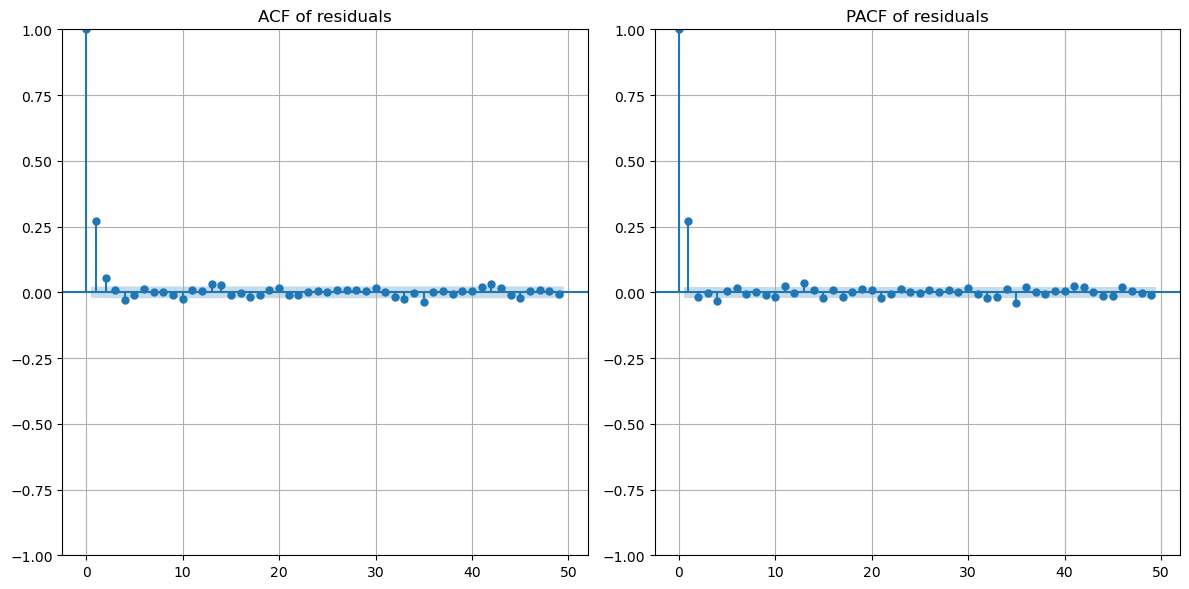

In [66]:
plt.figure(figsize = (12, 6))
# ACF Plot
plt.subplot(1, 2, 1)
plot_acf(residuals_tes, ax=plt.gca(), lags = range(0, 50))
# plt.ylim(-0.1, 0.1)
plt.title('ACF of residuals')
plt.grid(True)
# PACF Plot
plt.subplot(1, 2, 2)
plot_pacf(residuals_tes, ax=plt.gca(), lags = range(0, 50), method = 'ywm')
# plt.ylim(-0.1, 0.1)
plt.title('PACF of residuals')
plt.grid(True)
plt.tight_layout()

plt.show()

In [62]:
%%time
# Fit Auto ARIMA model
model = auto_arima(
    residuals_tes, # original series (let auto_arima handle differencing)
    start_p = 1, max_p = 50, 
    start_q = 1, max_q = 50,
    d = None,            # let auto_arima determine differencing order
    seasonal=False,      # set True if data is seasonal
    stepwise=True,       # use stepwise search (faster)
    suppress_warnings=True,
    trace=True,           # print model fitting progress
    n_jobs = -1
)
# Summary of the model
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-28795.491, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-28115.350, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-28794.366, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-28771.972, Time=0.40 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-28793.548, Time=0.55 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-28793.261, Time=0.48 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-28792.593, Time=0.42 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-28795.482, Time=0.17 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-28791.703, Time=1.22 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-28793.528, Time=0.68 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 4.629 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8909
Model:               SARIMAX(1, 0, 1)   Lo

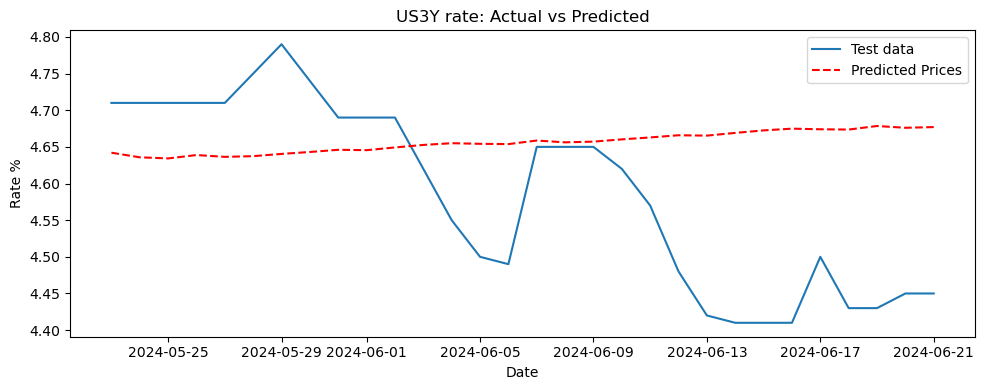

RMSE:  0.15323


In [65]:
# Fit the ARIMA model (ARIMA) to the training residual data
model = ARIMA(residuals_tes, order=(1, 0, 1))
model_res_arima = model.fit()

# Make predictions on residue
pred_res = model_res_arima.forecast(steps=n_periods, dynamic=False)

final_forecast = pred_tes + pred_res
 
# Plot the actual vs predicted values
test_plot(test_true, final_forecast)

# evaluating model using RMSE score
rmse = round(np.sqrt(mean_squared_error(test_true, final_forecast)), 5)
print('RMSE: ', rmse)